In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
from lib.Stream import Stream
from lib.TimeNode import TimeNode
from lib.StreamProperties import StreamStarSat
from lib.Graph import Graph, StarSat, BHACore
import networkx as nx
import matplotlib.pyplot as plt
import logging
import StreamFig
from IPython.display import Image, clear_output

Faire des minidonnées de test, calculer l'intérieur (pour des propriétés de degrés genre hub-autorité etc.)

In [77]:
s = Stream(lang=set("abcd"), _loglevel=logging.DEBUG)
core_property = StreamStarSat(s, threshold=3)
s.setCoreProperty(core_property)
#s.readStream("./tests/ChangingNeighbours-StSa-Copy1.json")
s.readStream("./tests/integration/fixtures/ChangingNeighbours-StSa-Copy1.json")
s.T

{'alpha': 0, 'omega': 10}

In [78]:
X1 = [(x["u"], (x["b"], x["e"])) for x in s.E ]
X2 = [(x["v"], (x["b"], x["e"])) for x in s.E ]

X = X1 + X2
interior = s.interior(X, X)
print(interior)

({v [2, 3]}, {u [2, 3], y [2, 3], x [2, 3]})


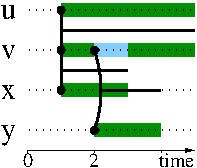

In [79]:
# Draw
s_draw = StreamFig.StreamFig(alpha=0, omega=5, streaming=False)
_ = [s_draw.addNode(x) for x in s.nodes()]
for l in s.E:
    if set([l["u"], l["v"]]) == set(["v", "y"]):
        s_draw.addLink(l["u"], l["v"], l["b"], l["e"], curving=0.2)
    else:
        s_draw.addLink(l["u"], l["v"], l["b"], l["e"])
    
    
# draw star
for nc in interior[0].values():
    s_draw.addNodeCluster(nc.node, [(nc.b, nc.e)], color=11)
# draw sat
for nc in interior[1].values():
    s_draw.addNodeCluster(nc.node, [(nc.b, nc.e)], color=12)
    
s_draw.addTimeLine(ticks=2)
s_draw.save("test.fig")
# For display
del s_draw
from subprocess import call
call("rm test.png", shell=True)
call("fig2dev -Lpng test.fig > test.png", shell=True)
clear_output()
Image("test.png")

In [80]:
s.I

{'a', 'b', 'c', 'd'}

In [81]:
s.bipatterns(X1, X2)

{'a', 'b'} ({v [2, 3]}, {u [2, 3], y [2, 3], x [2, 3]})
{'a', 'd', 'b'} ({v [2, 3]}, {y [2, 3], u [2, 3]})
{'a', 'd', 'c', 'b'} ({v [2, 3]}, {u [2, 3]})


In [ ]:
s.fp_close()

In [ ]:
s = Stream(lang=set("abcd"), _loglevel=logging.DEBUG)
core_property = StreamStarSat(s, threshold=2)
s.setCoreProperty(core_property)
s.readStream("./tests/testJaccard.json")

def jaccard(s, u, v):
    """ 
        u,v : two nodes
        
        @return: the Jaccard coefficient of u and v
    """
    jaccard = 0.0
    
    n_u = [ TimeNode(x, b, e) for x in s.neighbours(u) for b,e,l_u,l_v in s.times[frozenset([u, x])] ]
    n_v = [ TimeNode(x, b, e) for x in s.neighbours(v) for b,e,l_u,l_v in s.times[frozenset([v, x])] ]
    
    # Union
    union = sum(( x.e - x.b for x in set(n_u + n_v) ))
    
    # Intersection
    inter = sum( ( x.e - x.b for x in n_u if x in n_v ) )
    
    return inter / union

jaccard(s, "u", "v")

In [8]:
a = set([TimeNode("u", 1,3)])
b = set([TimeNode("u", 2,5)])